<a href="https://colab.research.google.com/github/akktrsst/Kaggle_Problems/blob/master/Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
!pip install datasets
!pip install stopwords

In [36]:
import torch
import datasets

dataset = datasets.load_dataset('tweets_hate_speech_detection')

In [37]:
# For simplicity let's remove alphanumeric but keep @, #
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

ss = SnowballStemmer('english')
sw = stopwords.words('english')

def split_tokens(row):                             # STEP
    row['all_tokens'] = [ss.stem(i) for i in       # 5
                     re.split(r" +",               # 3
                     re.sub(r"[^a-z@# ]", "",      # 2
                            row['tweet'].lower())) # 1
                     if (i not in sw) and len(i)]  # 4
    return row

# Determine vocabulary so we can create mapping
dataset = dataset.map(split_tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'tweet', 'all_tokens'],
        num_rows: 31962
    })
    test: Dataset({
        features: ['label', 'tweet', 'all_tokens'],
        num_rows: 17197
    })
})

In [39]:
from collections import Counter

counts = Counter([i for s in dataset['train']['all_tokens'] for i in s])
counts = {k:v for k, v in counts.items() if v>10} # Filtering
vocab = list(counts.keys())
n_v = len(vocab)
id2tok = dict(enumerate(vocab))
tok2id = {token: id for id, token in id2tok.items()}

# Now correct tokens
def remove_rare_tokens(row):
    row['tokens'] = [t for t in row['all_tokens'] if t in vocab]
    return row

dataset = dataset.map(remove_rare_tokens)

In [40]:
dataset['train'].features

{'label': ClassLabel(names=['no-hate-speech', 'hate-speech'], id=None),
 'tweet': Value(dtype='string', id=None),
 'all_tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [41]:
def windowizer(row, wsize=3):
    """
    Windowizer function for Word2Vec. Converts sentence to sliding-window
    pairs.
    """
    doc = row['tokens']
    wsize = 3
    out = []
    for i, wd in enumerate(doc):
        target = tok2id[wd]
        window = [i+j for j in
                  range(-wsize, wsize+1, 1)
                  if (i+j>=0) &
                     (i+j<len(doc)) &
                     (j!=0)]

        out+=[(target, tok2id[doc[w]]) for w in window]
    row['moving_window'] = out
    return row

dataset = dataset.map(windowizer)

In [42]:
dataset['train'].features['moving_window']

Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None)

In [58]:
dataset.keys()

dict_keys(['train', 'test'])

In [43]:
# dataset.set_format(type='pandas')
# df = dataset['train'][:]

In [44]:
# classes = dataset['train'].features['label'].names
# df['label_name']=df['label'].apply(lambda x:classes[x])
# df.head()

In [59]:
from torch.utils.data import Dataset, DataLoader

class Word2VecDataset(Dataset):
    """
    Takes a HuggingFace dataset as an input, to be used for a Word2Vec dataloader.
    """
    def __init__(self, dataset, vocab_size, wsize=3):
        self.dataset = dataset
        self.vocab_size = vocab_size
        self.data = [i for s in dataset['moving_window'] for i in s]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [62]:
BATCH_SIZE = 2**14
N_LOADER_PROCS = 10

dataloader = {}
# for key in dataset.keys():
dataloader = {'train': DataLoader(Word2VecDataset(
                                dataset['train'], vocab_size=n_v),
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=N_LOADER_PROCS),
              'test': DataLoader(Word2VecDataset(
                                dataset['test'], vocab_size=n_v),
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=N_LOADER_PROCS)}
# dataloader = {'test': DataLoader(Word2VecDataset(
#                                 dataset['test'], vocab_size=n_v),
#                               batch_size=BATCH_SIZE,
#                               shuffle=True,
#                               num_workers=N_LOADER_PROCS)}

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [63]:
dataloader.keys()

dict_keys(['train', 'test'])

In [47]:
dataloader

{'test': <torch.utils.data.dataloader.DataLoader at 0x7f027b401e70>}

In [48]:
# There are two variants of this architecture:

# CBOW (continuous bag-of-words): context word is input, center word is output.
# Skip-gram: center word is input, context word is output.

In [49]:
# Aside: manually implementing one-hot encoding

In [64]:
from torch import nn

size = 10
input = 3

def one_hot_encode(input, size):
    vec = torch.zeros(size).float()
    vec[input] = 1.0
    return vec

ohe = one_hot_encode(input, size)
linear_layer = nn.Linear(size, 1, bias=False)

# Set edge weights from 0 to 9 for easy reference
with torch.no_grad():
    linear_layer.weight = nn.Parameter(
        torch.arange(10, dtype=torch.float).reshape(linear_layer.weight.shape))

print(linear_layer.weight)
print(linear_layer(ohe))

Parameter containing:
tensor([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]], requires_grad=True)
tensor([3.], grad_fn=<SqueezeBackward4>)


In [65]:
embedding_layer = nn.Embedding(size, 1)

with torch.no_grad():
    embedding_layer.weight = nn.Parameter(
        torch.arange(10, dtype=torch.float
        ).reshape(embedding_layer.weight.shape))

print(embedding_layer.weight)
print(embedding_layer(torch.tensor(input)))

Parameter containing:
tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]], requires_grad=True)
tensor([3.], grad_fn=<EmbeddingBackward0>)


In [66]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.expand = nn.Linear(embedding_size, vocab_size, bias=False)

    def forward(self, input):
        # Encode input to lower-dimensional representation
        hidden = self.embed(input)
        # Expand hidden layer to predictions
        logits = self.expand(hidden)
        return logits

Training

In [67]:
EMBED_SIZE = 100 # Quite small, just for the tutorial
model = Word2Vec(n_v, EMBED_SIZE)

# Relevant if you have a GPU:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define training parameters
LR = 3e-4
EPOCHS = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

In [68]:
print(dataloader.keys())

dict_keys(['train', 'test'])


In [69]:
from tqdm import tqdm  # For progress bars

progress_bar = tqdm(range(EPOCHS * len(dataloader['train'])))
running_loss = []
for epoch in range(EPOCHS):
    epoch_loss = 0
    for center, context in dataloader['train']:
        center, context = center.to(device), context.to(device)
        optimizer.zero_grad()
        logits = model(input=context)
        loss = loss_fn(logits, center)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.update(1)
    epoch_loss /= len(dataloader['train'])
    running_loss.append(epoch_loss)

100%|██████████| 530/530 [14:14<00:00,  1.18s/it]

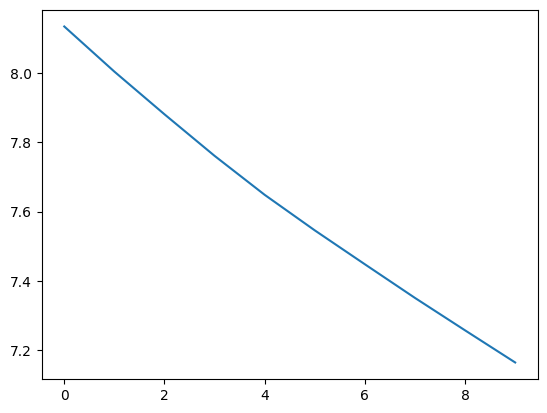

In [70]:
import matplotlib.pyplot as plt
plt.plot(running_loss)

In [72]:
wordvecs = model.expand.weight.cpu().detach().numpy()
tokens = ['good', 'father', 'school', 'hate']

In [73]:
from scipy.spatial import distance
import numpy as np

def get_distance_matrix(wordvecs, metric):
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix

def get_k_similar_words(word, dist_matrix, k=10):
    idx = tok2id[word]
    dists = dist_matrix[idx]
    ind = np.argpartition(dists, k)[:k+1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, id2tok[i], dists[i]) for i in ind]
    return out

dmat = get_distance_matrix(wordvecs, 'cosine')
for word in tokens:
    print(word, [t[1] for t in get_k_similar_words(word, dmat)], "\n")

good ['go', 'news', 'yeah', 'friend', 'tomorrow', 'everi', 'bong', 'amp', 'anoth', 'hope'] 

father ['dad', 'happi', '#fathersday', 'day', 'great', 'wish', '#father', '#love', 'know', 'dont'] 

school ['tomorrow', 'today', 'get', 'first', 'come', 'back', 'night', 'next', 'two', 'noth'] 

hate ['amp', 'today', 'like', 'watch', 'one', 'make', 'thing', '@user', 'im', 'man'] 



In [71]:
## https://muhark.github.io/python/ml/nlp/2021/10/21/word2vec-from-scratch.html